This notebook uses topotoolbox and gmsh to create a mesh of the drainage basin around a subglacial lake. For now, the draianage basin boundary is traced by hand in matplotlib.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
sys.path.insert(0, '../source')
sys.path.insert(0, '../scripts')
import os
from netCDF4 import Dataset
from scipy.interpolate import griddata
import topotoolbox as tt3
import matplotlib.pyplot as plt
from shapely import get_coordinates
from shapely.geometry import Polygon
import netCDF4 as nc
import geopandas as gpd
import gmsh
import pygmsh
import meshio
import rasterio
from rasterio.transform import from_bounds
from rasterio.crs import CRS

# List available subglacial lake names from Siegfried & Fricker (2018) inventory
from load_lakes import gdf
print(gdf['name'].to_list())

['Bindschadler_1', 'Bindschadler_2', 'Bindschadler_3', 'Bindschadler_4', 'Bindschadler_5', 'Bindschadler_6', 'Byrd_1', 'Byrd_2', 'Byrd_s1', 'Byrd_s10', 'Byrd_s11', 'Byrd_s12', 'Byrd_s13', 'Byrd_s14', 'Byrd_s15', 'Byrd_s2', 'Byrd_s3', 'Byrd_s4', 'Byrd_s5', 'Byrd_s6', 'Byrd_s7', 'Byrd_s8', 'Byrd_s9', 'ConwaySubglacialLake', 'Cook_E1', 'Cook_E2', 'David_1', 'David_s1', 'David_s2', 'David_s3', 'David_s4', 'David_s5', 'EAP_1', 'EAP_2', 'EAP_3', 'EAP_4', 'EAP_5', 'EAP_6', 'EAP_7', 'EAP_8', 'EAP_9', 'EngelhardtSubglacialLake', 'Foundation_1', 'Foundation_10', 'Foundation_11', 'Foundation_12', 'Foundation_13', 'Foundation_14', 'Foundation_15', 'Foundation_16', 'Foundation_2', 'Foundation_3', 'Foundation_4', 'Foundation_5', 'Foundation_6', 'Foundation_7', 'Foundation_8', 'Foundation_9', 'Foundation_N1', 'Foundation_N2', 'Foundation_N3', 'Institute_E1', 'Institute_E2', 'Institute_W1', 'Institute_W2', 'KT1', 'KT2', 'KT3', 'Kamb_1', 'Kamb_10', 'Kamb_11', 'Kamb_12', 'Kamb_2', 'Kamb_3', 'Kamb_4', 'K

In [2]:
lake_name = "Cook_E2"

In [3]:
# set path to ICESat-2 ATL14 data
paths = {}

paths['icesat'] = '/Users/agstubbl/Desktop/ICESat-2/ATL14_A4_0325_100m_004_05.nc'    
paths['bedmachine'] = '/Users/agstubbl/Desktop/bedmachine/BedMachineAntarctica-v3.nc'

In [4]:
outline = gdf.loc[gdf['name']==lake_name]
x0 = float(outline.centroid.x.iloc[0])*1e3
y0 = float(outline.centroid.y.iloc[0])*1e3

# Select half-width L0 of box surrounding lake
L0 = 50*1000
x_min = x0-L0
x_max = x0+L0
y_min = y0-L0
y_max = y0+L0

#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# load the ATL15 data
ds = nc.Dataset(paths['icesat'])

h = ds['h'][:]              # elevation (m)
x = ds['x'][:]               # x coordinate array (m)
y = ds['y'][:]               # y coordinate array (m)


ind_x = np.arange(0,np.size(x),1)
ind_y = np.arange(0,np.size(y),1)

# extract the data that is inside the bounding box
x_sub = x[(x>=x_min)&(x<=x_max)]
y_sub = y[(y>=y_min)&(y<=y_max)]
inds_x = ind_x[(x>=x_min)&(x<=x_max)]
inds_y = ind_y[(y>=y_min)&(y<=y_max)]

nx = np.size(inds_x)
ny = np.size(inds_y)

inds_xy = np.ix_(inds_y,inds_x)
h_sub = np.zeros((ny,nx))

# put elevation change maps into 3D array with time being the first index
h_sub = h[inds_xy]
X_sub,Y_sub = np.meshgrid(x_sub,y_sub)

In [5]:
# load and subset bedmachine data
bedmachine = Dataset(paths['bedmachine'])
x_bm = bedmachine['x'][:].data.astype(np.float64)
y_bm = bedmachine['y'][:].data.astype(np.float64)
bed_bm = bedmachine['bed'][:].data.astype(np.float64)
xb_sub = x_bm[(x_bm>=x_min)&(x_bm<=x_max)]
yb_sub = y_bm[(y_bm>=y_min)&(y_bm<=y_max)]
ind_x = np.arange(0,np.size(x_bm),1)
ind_y = np.arange(0,np.size(y_bm),1)
inds_x = ind_x[(x_bm>=x_min)&(x_bm<=x_max)]
inds_y = ind_y[(y_bm>=y_min)&(y_bm<=y_max)]
nx = np.size(inds_x)
ny = np.size(inds_y)
inds_xy = np.ix_(inds_y,inds_x)
bed_sub = np.zeros((ny,nx))
bed_sub = bed_bm[inds_xy]

X_bm, Y_bm = np.meshgrid(xb_sub,yb_sub)

In [6]:
# define a common grid to interpolate bedmachine and icesat-2 
x_g = np.linspace(x_min,x_max,1000)
y_g = np.linspace(y_min,y_max,1000)
X_g, Y_g = np.meshgrid(x_g,y_g)

points1 = (X_sub.flatten(),Y_sub.flatten())
points2 = (X_bm.flatten(),Y_bm.flatten())

surf_interp = griddata(points1, h_sub.flatten(), (X_g, Y_g), method='nearest',fill_value='nearest')
bed_interp = griddata(points2, bed_sub.flatten(), (X_g, Y_g), method='nearest',fill_value='nearest')

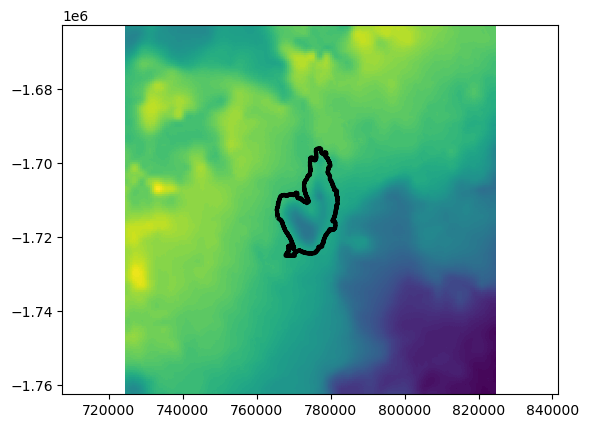

In [7]:
# define background hydraulic potential
rho_i = 917.0
g = 9.81
rho_w = 1000.0
potential = rho_i*g*surf_interp + (rho_w - rho_i)*g * bed_interp
outline_sc = outline.scale(xfact=1e3,yfact=1e3,origin=(0,0,0))

plt.contourf(X_g,Y_g,potential,levels=100)
outline_sc.plot(edgecolor='k',facecolor='none',ax=plt.gca(),linewidth=3)
plt.gca().axis('equal')
plt.show()
plt.close()

In [8]:
# normalize map to integer values in range [0,255]
potential_normalized = (potential - np.min(potential)) / (np.max(potential) - np.min(potential)) * 255
potential_normalized = potential_normalized.astype(np.uint8)

In [9]:
data = potential_normalized
west, south, east, north = x_sub.min(), y_sub.max(), x_sub.max(), y_sub.min()
width, height = data.shape[1], data.shape[0]
transform = from_bounds(west, south, east, north, width, height)
# print(transform)
crs = CRS.from_epsg(3031)

In [10]:
def save_numpy_array_to_geotiff(file_path, arr, profile):
    """
    Saves a NumPy array to a GeoTIFF file.

    Args:
        file_path (str): Path to save the GeoTIFF file.
        arr (numpy.ndarray): NumPy array to save.
        profile (dict): Rasterio dataset profile (metadata).
    """
    with rasterio.open(file_path, 'w', **profile) as dst:
        dst.write(arr, 1)

# Example Usage:
# Assuming 'data' is your numpy array and 'output.tif' is the desired file name
# 'crs' and 'transform' should be defined based on your data's spatial information
# Replace with appropriate values for your use case.
profile = {
    'driver': 'GTiff',
    'height': height,
    'width': width,
    'count': 1,
    'dtype': data.dtype,
    'crs': crs,
    'transform': transform,
}
save_numpy_array_to_geotiff('potenetial_dem.tif', data, profile)

In [22]:
dem = tt3.read_tif('potenetial_dem.tif')
fd = tt3.FlowObject(dem)

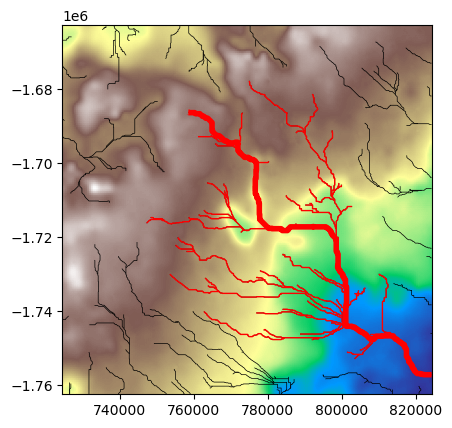

In [13]:
s   = tt3.StreamObject(fd,threshold=2000,units='pixels')
fig, ax = plt.subplots()
dem.plot(ax,cmap="terrain")
s.plot(ax=ax,color='k',linewidth=0.5)
(s.klargestconncomps(1)).plot(ax=ax,color='r',linewidth=1)
(s.klargestconncomps(1).trunk()).plot(ax=ax,color='r',linewidth=4)
plt.gca().invert_yaxis()
plt.show()
plt.close()

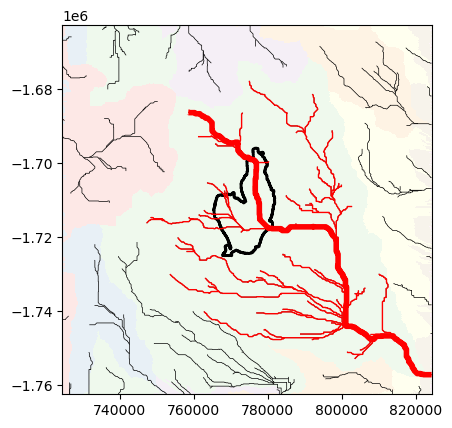

In [14]:
fig, ax = plt.subplots()
basins = fd.drainagebasins()
s.plot(ax=ax,color='k',linewidth=0.5)
(s.klargestconncomps(1)).plot(ax=ax,color='r',linewidth=1)
(s.klargestconncomps(1).trunk()).plot(ax=ax,color='r',linewidth=4)
basins.plot(cmap="Pastel1",interpolation="nearest",alpha=0.3)
outline_sc.plot(edgecolor='k',facecolor='none',ax=plt.gca(),linewidth=2)
plt.gca().invert_yaxis()
plt.show()
plt.close()

In [15]:
tt3.write_tif(basins, lake_name+'_basins.tif')

In [16]:
with rasterio.open(lake_name+'_basins.tif') as src:
    basins0 = src.read()[0]

In [17]:
%matplotlib tk
# Define extent
poly_list = []
outlines = gpd.GeoSeries(poly_list)
dx = (x_g[1]-x_g[0])/2.
dy = (y_g[1]-y_g[0])/2.
extent = [x_g[0]-dx, x_g[-1]+dx, y_g[0]-dy, y_g[-1]+dy]
plt.imshow(basins,cmap="Pastel1",interpolation='nearest',extent=extent,origin='lower')
outline_sc.plot(edgecolor='k',facecolor='none',ax=plt.gca(),linewidth=3)
plt.gca().axis('equal')

pts = plt.ginput(-1,timeout=-1)
poly_list.append(Polygon(pts))
outlines = gpd.GeoSeries(poly_list)
outlines.plot(edgecolor='k',facecolor='none',ax=plt.gca(),linewidth=3)
plt.pause(2)
plt.close()
outline = outlines[0]
plt.show()


In [20]:
# write mesh file of basin boundary with gmsh
# outline is a geoseries 

coords = get_coordinates(outline.boundary)
coords = coords[0:coords.shape[0]-1,:] # delete last coordinate so there's no overlap

# Create model
geometry = pygmsh.geo.Geometry()
model = geometry.__enter__()
resolution = 2000 # element size in meters

points = []
for i in range(coords[:,0].size):
    points.append(model.add_point((coords[:,0][i], coords[:,1][i], 0), mesh_size=resolution))
    
lines = []
for i in range(-1, len(points) - 1):
    lines.append(model.add_line(points[i], points[i + 1])) 
    
# create loop
loop = model.add_curve_loop(lines)

# create plane surface
plane_surface = model.add_plane_surface(loop)

model.synchronize()

model.add_physical([plane_surface], "Area")

geometry.generate_mesh(dim=2)
gmsh.write(lake_name+"_mesh.msh")

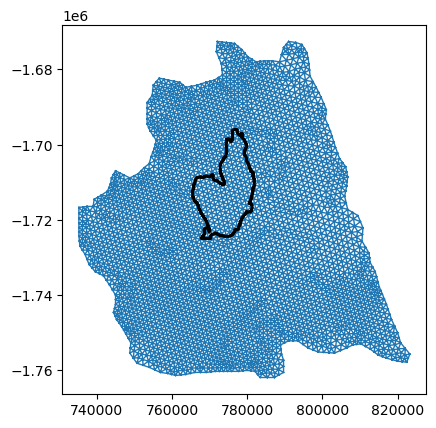

In [21]:
msh = meshio.read(lake_name+"_mesh.msh")

# 3. Plot the mesh using matplotlib
%matplotlib inline
points = msh.points
cells = msh.cells[0].data  # Assuming only one cell block
plt.triplot(points[:, 0], points[:, 1], cells,linewidth=1)
outline_sc.plot(edgecolor='k',facecolor='none',ax=plt.gca(),linewidth=2)
plt.gca().set_aspect("equal")
plt.show()
plt.close()